<a href="https://colab.research.google.com/github/talha-q/talha_Geo6805/blob/main/Assignment%204%20Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!rm -r "/content/chipped_dataset/"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Let's import the necessary libraries in first
import os
import torch
import torch.nn as nn # nn is the linear transformation function in PyTorch, it is the fully connected layer
import torch.optim as optim # optim is the optimization function in PyTorch, the gradient descent algorithm(adam, sdg)
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import timm #this one contains the pre-trained models
import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
from glob import glob
from pathlib import Path

from osgeo import gdal
from glob import glob
from collections import defaultdict

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Torchvision version 0.21.0+cu124
Numpy version 2.0.2
Pandas version 2.2.2


In [5]:
!rm -r /content/chipped_dataset/


rm: cannot remove '/content/chipped_dataset/': No such file or directory


##Assignment 1 Chipping the images and storing them

In [6]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from osgeo import gdal
from glob import glob
from tqdm import tqdm

# === Relabel function ===
def relabel_mask(mask):
    mask = np.where((mask == 2) | (mask == 3), 4, mask)
    mask = np.where(mask == 1, 0, mask)
    mask = np.where(mask == 4, 1, mask)
    return mask

# === Dataset class ===
class SegmentationDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.img_files = sorted(glob(os.path.join(self.img_dir, "PS", "*.[tT][iI][fF]")))

    def __len__(self):
        return len(self.img_files)

    def _read_image(self, img_path):
        ds = gdal.Open(img_path)
        self.geotransform = ds.GetGeoTransform()
        self.projection = ds.GetProjection()
        num_bands = ds.RasterCount

        bands = [ds.GetRasterBand(i + 1).ReadAsArray().astype(np.uint8) for i in range(num_bands)]
        image = np.stack(bands, axis=0)
        return image

    def _read_label(self, label_path):
        ds = gdal.Open(label_path)
        label = ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)
        return label

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        label_path = img_path.replace("PS", "labels")

        image = self._read_image(img_path)
        label = self._read_label(label_path)

        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).long()

        return image, label, os.path.splitext(os.path.basename(img_path))[0], self.geotransform, self.projection

# === Save chips ===
def chip_and_save(image, label, img_name, out_img_dir, out_lbl_dir,
                  chip_size=256, stride=256, geotransform=None, projection=None):
    h, w = image.shape[1:]
    num_bands = image.shape[0]
    count = 0

    for i in range(0, h, stride):
        for j in range(0, w, stride):
            i_end = min(i + chip_size, h)
            j_end = min(j + chip_size, w)
            i_start = i_end - chip_size
            j_start = j_end - chip_size
            if i_start < 0 or j_start < 0:
                continue

            img_chip = image[:, i_start:i_end, j_start:j_end]
            lbl_chip = label[i_start:i_end, j_start:j_end]

            if img_chip.shape[1:] != (chip_size, chip_size):
                continue

            chip_name = f"{img_name}_chip_{count}.tif"
            img_chip_path = os.path.join(out_img_dir, chip_name)
            lbl_chip_path = os.path.join(out_lbl_dir, chip_name)

            driver = gdal.GetDriverByName('GTiff')
            img_ds = driver.Create(img_chip_path, chip_size, chip_size, num_bands, gdal.GDT_Byte)
            lbl_ds = driver.Create(lbl_chip_path, chip_size, chip_size, 1, gdal.GDT_Byte)

            if geotransform:
                origin_x = geotransform[0] + j_start * geotransform[1]
                origin_y = geotransform[3] + i_start * geotransform[5]
                chip_transform = (origin_x, geotransform[1], 0.0, origin_y, 0.0, geotransform[5])
                img_ds.SetGeoTransform(chip_transform)
                lbl_ds.SetGeoTransform(chip_transform)
                if projection:
                    img_ds.SetProjection(projection)
                    lbl_ds.SetProjection(projection)

            for band_num in range(num_bands):
                img_ds.GetRasterBand(band_num + 1).WriteArray(img_chip[band_num].numpy())
            lbl_ds.GetRasterBand(1).WriteArray(lbl_chip.numpy())

            img_ds = None
            lbl_ds = None
            count += 1

# === Main chipping function ===
def chip_dataset(root_img_dir, output_root, chip_size=256):
    out_img_dir = os.path.join(output_root, "PS")
    out_lbl_dir = os.path.join(output_root, "labels")
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    dataset = SegmentationDataset(root_img_dir)

    for i in range(len(dataset)):
        image, label, img_name, gt, proj = dataset[i]
        label = torch.from_numpy(relabel_mask(label.numpy()))
        chip_and_save(image, label, img_name, out_img_dir, out_lbl_dir, chip_size=chip_size,
                      geotransform=gt, projection=proj)

# === Function to print shapes of saved chips ===
def print_chipped_shapes(chipped_folder):
    img_files = sorted(glob(os.path.join(chipped_folder, "PS", "*.tif")))
    print(f"\n✅ Total chipped images: {len(img_files)}\n")

    for f in img_files:
        ds = gdal.Open(f)
        width = ds.RasterXSize
        height = ds.RasterYSize
        bands = ds.RasterCount
        print(f"{os.path.basename(f)} - Shape: {height} x {width}, Bands: {bands}")

# === Run it all ===
if __name__ == "__main__":
    input_folder = "/content/drive/MyDrive/GlobalSurfaceWaterDataset(1)/GlobalSurfaceWaterDataset"
    output_folder = "chipped_dataset"

    chip_dataset(input_folder, output_folder)


Checking the size and bands of images

In [7]:
import os
from osgeo import gdal
from glob import glob

# Path to your images
#image_dir = "/content/drive/MyDrive/GlobalSurfaceWaterDataset(1)/GlobalSurfaceWaterDataset/PS"
image_dir = "/content/chipped_dataset/PS"


image_paths = sorted(glob(os.path.join(image_dir, "*.tif")))

print(f"Found {len(image_paths)} TIFF images.\n")

for path in image_paths:
    ds = gdal.Open(path)
    if ds is None:
        print(f"Could not open {os.path.basename(path)}")
        continue

    width = ds.RasterXSize
    height = ds.RasterYSize
    bands = ds.RasterCount
    num_pixels = height * width * bands
    size_mb = os.path.getsize(path) / (1024 * 1024)

    print(f"{os.path.basename(path)} → "
          f"Shape: {height}x{width}, "
          f"Bands: {bands}, "
          f"Total Pixels: {num_pixels}, "
          f"Size: {size_mb:.2f} MB")


Found 1811 TIFF images.

SID01_chip_0.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_1.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_10.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_11.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_12.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_13.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_14.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_15.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_16.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_17.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_18.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_19.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0

In [8]:
import os
import torch
import numpy as np
from osgeo import gdal
from glob import glob
from tqdm import tqdm
import pickle

# === Configuration ===
ps_folder = "/content/chipped_dataset/PS"  # <-- Update to your folder
num_bands = 8  # Red, Green, Blue, NIR

# === Load image paths ===
image_paths = sorted(glob(os.path.join(ps_folder, "*.tif")))
print(f"Found {len(image_paths)} images.")

# === Band-wise storage ===
flatnBandList = [[] for _ in range(num_bands)]

# === Process images ===
for path in tqdm(image_paths, desc="Reading images"):
    ds = gdal.Open(path)
    if ds is None:
        print(f" Could not open {path}")
        continue

    band_count = ds.RasterCount
    if band_count < num_bands:
        print(f" Skipping {os.path.basename(path)} — only {band_count} bands found.")
        continue

    for i in range(num_bands):
        band = ds.GetRasterBand(i + 1).ReadAsArray().astype(np.float32)
        flatnBandList[i].append(torch.from_numpy(band).flatten())

# === Compute stats ===
means, stds = [], []
for i, band_data in enumerate(flatnBandList):
    all_pixels = torch.cat(band_data)
    means.append(all_pixels.mean().item())
    stds.append(all_pixels.std().item())

# === Output ===
print("\nBand-wise Means:", means)
print(" Band-wise Standard Deviations:", stds)

# === Save to file (optional)
stats = {"means": means, "stds": stds}
with open("bandstats.pkl", "wb") as f:
    pickle.dump(stats, f)
print("Saved band stats to bandstats.pkl")


Found 1811 images.


Reading images: 100%|██████████| 1811/1811 [00:04<00:00, 368.44it/s]



Band-wise Means: [118.29904174804688, 129.00457763671875, 118.03889465332031, 120.23979949951172, 116.89582061767578, 121.523681640625, 120.2465591430664, 119.38862609863281]
 Band-wise Standard Deviations: [78.42156982421875, 77.57292938232422, 75.61328887939453, 75.92793273925781, 75.53909301757812, 76.77102661132812, 76.22856903076172, 75.55461883544922]
Saved band stats to bandstats.pkl


#Defining Z Norm

In [9]:
with open("bandstats.pkl", "rb") as f:
    loaded_stats = pickle.load(f)
class z_score_form_stats:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(-1, 1, 1)  # [C, 1, 1]
        self.std = torch.tensor(std).view(-1, 1, 1)

    def __call__(self, image):
        return (image - self.mean) / (self.std + 1e-6)


In [10]:
# from osgeo import gdal
# import numpy as np
# import torch

# # Load one sample image from your dataset
# path = "/content/chipped_dataset/images/SID01_chip_0.tif"  # Replace with any actual file path
# ds = gdal.Open(path)
# bands = [ds.GetRasterBand(i + 1).ReadAsArray().astype(np.float32) for i in range(8)]
# image_np = np.stack(bands, axis=0)  # shape: [C, H, W]

# # Convert and normalize
# image_tensor = torch.from_numpy(image_np).float()
# normalizer = z_score_form_stats(mean=loaded_stats["means"], std=loaded_stats["stds"])
# normalized = normalizer(image_tensor)

# # Print z-score stats for verification
# print(f"\n✅ Normalized shape: {normalized.shape}")
# print(f"Global mean: {normalized.mean():.4f}, std: {normalized.std():.4f}")

# # # Optional: Check per-band mean/std
# # for i in range(normalized.shape[0]):
# #     band = normalized[i]
# #     print(f"Band {i+1} → mean: {band.mean():.4f}, std: {band.std():.4f}")


Testing Znorm on a single image

In [11]:
# from osgeo import gdal
# import numpy as np
# import torch
# import pickle

# # Load stats from pickle
# with open("bandstats.pkl", "rb") as f:
#     loaded_stats = pickle.load(f)

# original_means = loaded_stats["means"]
# original_stds = loaded_stats["stds"]

# # Load one sample image
# path = "/content/chipped_dataset/images/SID01_chip_0.tif"
# ds = gdal.Open(path)
# bands = [ds.GetRasterBand(i + 1).ReadAsArray().astype(np.float32) for i in range(8)]
# image_np = np.stack(bands, axis=0)  # shape: [C, H, W]

# # Convert and normalize
# image_tensor = torch.from_numpy(image_np).float()
# normalizer = z_score_form_stats(mean=original_means, std=original_stds)
# normalized = normalizer(image_tensor)

# # Print global shape and stats
# print(f"\n Normalized shape: {normalized.shape}")
# print(f"Global mean: {normalized.mean():.4f}, std: {normalized.std():.4f}")

# # Compare per-band stats
# print("\n Band-wise Comparison:")
# for i in range(normalized.shape[0]):
#     band = normalized[i]
#     print(f"Band {i+1}: "
#           f"stored mean = {original_means[i]:.2f}, "
#           f"stored std = {original_stds[i]:.2f} → "
#           f"normalized mean = {band.mean():.4f}, "
#           f"normalized std = {band.std():.4f}")


In [12]:
#those are new libs compared to last time
from torchvision.transforms import v2 # this lib supports data augmentation
from torch.utils.data import Dataset, ConcatDataset


In [13]:
# important: the data augmentation methods takes input shape as (c,h,w) for both img and labels, but our label is actually (h,w), we need to add adimention when doing data augmentation to label. but the model loss eval actually takes only (h,w) for label. so after data augmentation, we need to convert label back to (w,h)
class SegmentationAugmentation:
    """Class containing all augmentation methods for segmentation tasks"""
    def no_augmentation(self, image, label):
        """Return image and label without any augmentation"""
        return image, label

    def horizontal_flip(self, image, label):
        """Apply horizontal flip to both image and label (spatial transform)"""
        image = v2.functional.horizontal_flip(image)
        label = label.unsqueeze(0) # convert label to (c,w,h)
        label = v2.functional.horizontal_flip(label)
        return image, label

    def vertical_flip(self, image, label):
        """Apply vertical flip to both image and label (spatial transform)"""
        image = v2.functional.vertical_flip(image)
        label = label.unsqueeze(0)
        label = v2.functional.vertical_flip(label)
        return image, label

    def rotate_90(self, image, label):
        """Apply 90-degree rotation to both image and label (spatial transform)"""
        image = v2.functional.rotate(image, 90)
        label = label.unsqueeze(0)
        label = v2.functional.rotate(label, 90, interpolation=v2.InterpolationMode.NEAREST)
        return image, label

    # We will not do random crop this time since they need to be resized, and we definately do not want to resize the label. Resizing will generate synsetic data that
    # will provide false information to the model

    def color_jitter(self, image, label, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
        """Apply color augmentations to image only (non-spatial transform)"""
        # Only modify the image, not the label
        if image.shape[0] >= 3:  # Only if we have RGB channels
            if torch.rand(1) > 0.5:
                image[:3] = v2.functional.adjust_brightness(
                    image[:3], 1.0 + torch.empty(1).uniform_(-brightness, brightness).item()
                )
            if torch.rand(1) > 0.5:
                image[:3] = v2.functional.adjust_contrast(
                    image[:3], 1.0 + torch.empty(1).uniform_(-contrast, contrast).item()
                )
            if torch.rand(1) > 0.5:
                image[:3] = v2.functional.adjust_saturation(
                    image[:3], 1.0 + torch.empty(1).uniform_(-saturation, saturation).item()
                )
            if torch.rand(1) > 0.5:
                image[:3] = v2.functional.adjust_hue(
                    image[:3], torch.empty(1).uniform_(-hue, hue).item()
                )

        # Label remains unchanged
        return image, label




In [14]:
import os
import torch
import numpy as np
from osgeo import gdal
from glob import glob
from torch.utils.data import Dataset
import pickle

# === Load global normalization stats from pickle ===
with open("bandstats.pkl", "rb") as f:
    loaded_stats = pickle.load(f)

# === Define the z-score normalization class ===
class z_score_form_stats:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def __call__(self, image):
        return (image - self.mean) / (self.std + 1e-6)

# === Main Dataset class ===
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, augmentation_method=None, sensor='rgb', normalize=True, mode='folder'):
        self.img_dir = img_dir
        self.augmentation_method = augmentation_method
        self.sensor = sensor
        self.normalize = normalize
        self.mode = mode
        self.augmentation = SegmentationAugmentation()

        # Use global stats if normalization is enabled
        if self.normalize:
            self.normalizer = z_score_form_stats(
                mean=loaded_stats["means"],
                std=loaded_stats["stds"]
            )

        # Find image files
        if self.mode == 'folder':
            self.img_files = sorted(glob(os.path.join(self.img_dir, "PS", "*.[tT][iI][fF]"), recursive=True))
        elif self.mode == 'list':
            self.img_files = self.img_dir

    def __len__(self):
        return len(self.img_files)

    def _read_image(self, img_path):
        image_file = gdal.Open(img_path)
        if self.sensor == 'rgb':
            bands = [image_file.GetRasterBand(i + 1).ReadAsArray().astype(np.int8) for i in range(3)]
        elif self.sensor == 'planet':
            bands = [image_file.GetRasterBand(i + 1).ReadAsArray().astype(np.int16) for i in range(8)]
        elif self.sensor == 's1':
            bands = [image_file.GetRasterBand(i + 1).ReadAsArray().astype(np.float16) for i in range(2)]
        else:
            raise ValueError(f"Sensor {self.sensor} not supported")
        return np.stack(bands, axis=0)

    def _read_label(self, label_path):
        label_file = gdal.Open(label_path)
        return label_file.GetRasterBand(1).ReadAsArray().astype(np.int8)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        label_path = img_path.replace("PS", "labels")

        image = self._read_image(img_path)
        label = self._read_label(label_path)

        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).long()

        if self.augmentation_method:
            aug_method = getattr(self.augmentation, self.augmentation_method)
            image, label = aug_method(image, label)

        if label.dim() == 3:
            label = label.squeeze(0)

        if self.normalize:
            image = self.normalizer(image)

        return image, label


In [15]:
# Create a combined dataset with all augmentation types. This is a test and demonstration, follow model training part for actual usage
img_dir = '/content/chipped_dataset'
sensor = 'planet'

original_dataset = SegmentationDataset(img_dir=img_dir, augmentation_method='no_augmentation', sensor=sensor)

combined_dataset = ConcatDataset([
    # Original images without augmentation
    SegmentationDataset(
        img_dir=img_dir,
        augmentation_method=None,
        sensor=sensor
    ),

    # Horizontally flipped images
    SegmentationDataset(
        img_dir=img_dir,
        augmentation_method='horizontal_flip',
        sensor=sensor
    ),

    # Vertically flipped images
    SegmentationDataset(
        img_dir=img_dir,
        augmentation_method='vertical_flip',
        sensor=sensor
    ),

    # 90-degree rotated images
    SegmentationDataset(
        img_dir=img_dir,
        augmentation_method='rotate_90',
        sensor=sensor
    ),

    # Color augmented images
    SegmentationDataset(
        img_dir=img_dir,
        augmentation_method='color_jitter',
        sensor=sensor
    )
])

#Below is test code to test if the code works
print(len(original_dataset))
print(len(combined_dataset))


# Create the dataloader
dataloader = DataLoader(
    combined_dataset,
    batch_size=8,
    shuffle=True
)

1811
9055


#Assignment 2 UNET MODEL CLASS

In [16]:
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling with transposed convolution then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Transposed convolution (deconvolution)
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2,
                                    kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # Concatenate along the channels dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = Up(512 + 512, 512)
        self.up2 = Up(256 + 256, 256)
        self.up3 = Up(128 + 128, 128)
        self.up4 = Up(64 + 64, 64)

        self.out_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        #self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.out_conv(x)
        return logits

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """MaxPool then DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layer = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.layer(x)

class Up(nn.Module):
    """Upsample then DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Padding to handle possible mismatch in size
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Extended encoder
        self.first_conv = DoubleConv(n_channels, 32)
        self.down0 = Down(32, 64)

        # Standard encoder
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        # Decoder path (symmetrical)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.up5 = Up(64, 32)  # Match first_conv skip connection

        # Final output layer
        self.out_conv = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        x0 = self.first_conv(x)     # [B, 32, H, W]
        x1 = self.down0(x0)         # [B, 64, H/2, W/2]
        x2 = self.down1(x1)         # [B, 128, H/4, W/4]
        x3 = self.down2(x2)         # [B, 256, H/8, W/8]
        x4 = self.down3(x3)         # [B, 512, H/16, W/16]
        x5 = self.down4(x4)         # [B, 1024, H/32, W/32]

        x = self.up1(x5, x4)        # [B, 512, H/16, W/16]
        x = self.up2(x, x3)         # [B, 256, H/8, W/8]
        x = self.up3(x, x2)         # [B, 128, H/4, W/4]
        x = self.up4(x, x1)         # [B, 64, H/2, W/2]
        x = self.up5(x, x0)         # [B, 32, H, W]

        return self.out_conv(x)


In [18]:
!pip install torch-lr-finder


Using device: cuda
1811
Finding optimal learning rate...


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
Suggested learning rate: 4.977024


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Batch 0/815, Loss: 0.8623
Epoch 1/50, Batch 10/815, Loss: 1.9219
Epoch 1/50, Batch 20/815, Loss: 1.0943
Epoch 1/50, Batch 30/815, Loss: 0.6597
Epoch 1/50, Batch 40/815, Loss: 0.6106
Epoch 1/50, Batch 50/815, Loss: 0.4541
Epoch 1/50, Batch 60/815, Loss: 0.4742
Epoch 1/50, Batch 70/815, Loss: 0.8065
Epoch 1/50, Batch 80/815, Loss: 0.4612
Epoch 1/50, Batch 90/815, Loss: 0.6124
Epoch 1/50, Batch 100/815, Loss: 0.7569
Epoch 1/50, Batch 110/815, Loss: 1.4468
Epoch 1/50, Batch 120/815, Loss: 0.6691
Epoch 1/50, Batch 130/815, Loss: 0.6355
Epoch 1/50, Batch 140/815, Loss: 0.6964
Epoch 1/50, Batch 150/815, Loss: 1.3013
Epoch 1/50, Batch 160/815, Loss: 0.5535
Epoch 1/50, Batch 170/815, Loss: 0.6917
Epoch 1/50, Batch 180/815, Loss: 0.7527
Epoch 1/50, Batch 190/815, Loss: 0.5308
Epoch 1/50, Batch 200/815, Loss: 0.8979
Epoch 1/50, Batch 210/815, Loss: 0.7717
Epoch 1/50, Batch 220/815, Loss: 0.9663
Epoch 1/50, Batch 230/815, Loss: 0.9599
Epoch 1/50, Batch 240/815, Loss: 0.3878
Epoch 1/50,

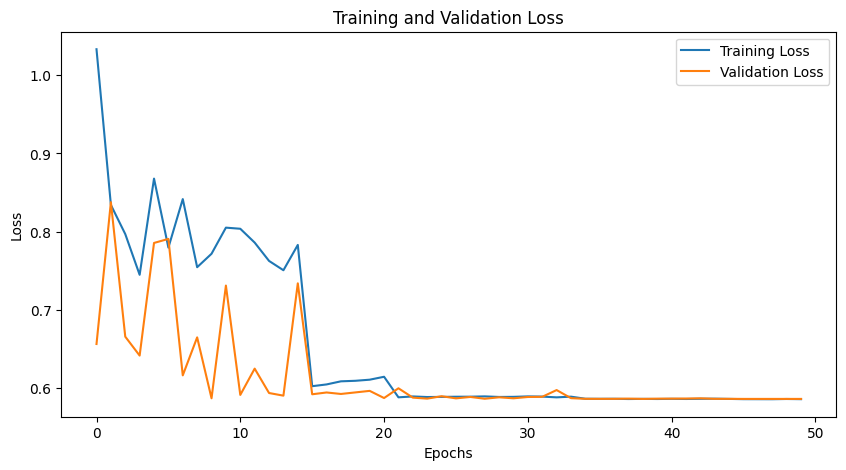

In [19]:
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import random_split
# you might need to install LRFinder through pip or conda
# conda install -c anaconda torch-lr-finder
from torch_lr_finder import LRFinder
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(f'Using device: {device}')

# Create output directory for checkpoints
checkpoint_dir = Path('./checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

def train_unet(
    img_dir,
    epochs=50,
    batch_size=8,
    n_classes=2,
    n_channels=8,
    sensor='planet',
    initial_lr=1e-4,  # Will be overridden by LR finder
    val_percent=0.2,
    patience=5
):
    # 1. Create model
    model = UNet(n_channels=n_channels, n_classes=n_classes)
    model.to(device)

    # 2. Create datasets
    # Original images without augmentation for validation
    dataset_all = SegmentationDataset(
        img_dir=img_dir,
        augmentation_method='no_augmentation',
        sensor=sensor,
        mode = 'folder'
    )
    print(len(dataset_all))

    train_size = int(0.9 * len(dataset_all))
    val_size = len(dataset_all) - train_size

    train_split, val_split = random_split(dataset_all, [train_size, val_size])

    # Extract each subset’s indices
    train_indices = train_split.indices
    val_indices   = val_split.indices

    # Map indices to the original file paths in full_dataset
    train_paths = [dataset_all.img_files[i] for i in train_indices]
    val_paths   = [dataset_all.img_files[i] for i in val_indices]

    # Combined dataset with augmentations for training
    train_dataset = ConcatDataset([
        # Original images
        SegmentationDataset(
            img_dir=train_paths,
            augmentation_method=None,
            sensor=sensor,
            mode = 'list'
        ),
        # Horizontally flipped images
        SegmentationDataset(
            img_dir=train_paths,
            augmentation_method='horizontal_flip',
            sensor=sensor,
            mode = 'list'
        ),
        # Vertically flipped images
        SegmentationDataset(
            img_dir=train_paths,
            augmentation_method='vertical_flip',
            sensor=sensor,
            mode = 'list'
        ),
        # 90-degree rotated images
        SegmentationDataset(
            img_dir=train_paths,
            augmentation_method='rotate_90',
            sensor=sensor,
            mode = 'list'
        )
    ])

    val_dataset = SegmentationDataset(img_dir=val_paths, augmentation_method=None, sensor = sensor, mode = 'list')

    # 3. Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True
    )

    # 4. Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)

    # 5. Find the optimal learning rate
    print("Finding optimal learning rate...")
    lr_finder = LRFinder(model, optimizer, criterion, device=device)
    lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
    # suggested_lr = lr_finder.suggest_lr()
    history = lr_finder.history
    suggested_lr = history["lr"][np.argmin(np.gradient(history["loss"]))]
    print(f"Suggested learning rate: {suggested_lr:.6f}")

    # Reset the model and optimizer with the found learning rate
    model = UNet(n_channels=n_channels, n_classes=n_classes)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=suggested_lr)

    # 6. Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=patience, verbose=True
    )

    # 7. Training loop
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0

        for batch_idx, (images, masks) in enumerate(train_loader):
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            # loss = criterion(outputs, masks.squeeze(1))
            loss = criterion(outputs, masks)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Track loss
            epoch_loss += loss.item()

            # Print progress
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)


                # batch_loss = criterion(outputs, masks.squeeze(1))
                batch_loss = criterion(outputs, masks)

                val_loss += batch_loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Update learning rate based on validation loss
        scheduler.step(avg_val_loss)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_dir / 'best_model.pth')
            print(f"Model saved at epoch {epoch+1} with validation loss: {best_val_loss:.4f}")

        # Save checkpoint every 10 epochs
        if (epoch + 1) % 50 == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, checkpoint_dir / f'checkpoint_epoch_{epoch+1}.pth')

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig('loss_plot.png')

    return model, train_losses, val_losses

if __name__ == "__main__":
    # Set your parameters
    img_dir = '/content/chipped_dataset'

    # Train the model
    model, train_losses, val_losses = train_unet(
        img_dir=img_dir,
        epochs=50,
        batch_size=8,
        n_classes=2,  # Binary segmentation
        n_channels=8,  # ps 8 channel images
        sensor='planet'
    )

#Assignment 3
6 Folds F1 and IOU

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, jaccard_score


In [24]:
def train_unet_crossval(
    img_dir,
    epochs=5,
    batch_size=8,
    n_classes=2,
    n_channels=8,
    sensor='planet',
    initial_lr=1e-4,
    patience=5,
    n_splits=6,
    train_folds=[0, 1]  # Only train on first two folds as requested
):
    # 1. Create dataset
    dataset_all = SegmentationDataset(
        img_dir=img_dir,
        augmentation_method='no_augmentation',
        sensor=sensor,
        mode='folder'
    )

    # 2. Setup KFold cross validation
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_indices = list(range(len(dataset_all)))

    # Store results
    fold_results = []
    best_model = None
    best_val_loss = float('inf')

    # 3. Perform cross-validation
    for fold, (train_indices, val_indices) in enumerate(kfold.split(all_indices)):
        print(f"\n=== Fold {fold + 1}/{n_splits} ===")

        # Skip folds we're not training on (as per requirement #1)
        if fold not in train_folds:
            continue

        # Get file paths for each split
        train_paths = [dataset_all.img_files[i] for i in train_indices]
        val_paths = [dataset_all.img_files[i] for i in val_indices]

        # Create datasets with augmentations for training
        train_dataset = ConcatDataset([
            SegmentationDataset(
                img_dir=train_paths,
                augmentation_method=None,
                sensor=sensor,
                mode='list'
            ),
            SegmentationDataset(
                img_dir=train_paths,
                augmentation_method='horizontal_flip',
                sensor=sensor,
                mode='list'
            ),
            SegmentationDataset(
                img_dir=train_paths,
                augmentation_method='vertical_flip',
                sensor=sensor,
                mode='list'
            ),
            SegmentationDataset(
                img_dir=train_paths,
                augmentation_method='rotate_90',
                sensor=sensor,
                mode='list'
            )
        ])

        val_dataset = SegmentationDataset(
            img_dir=val_paths,
            augmentation_method=None,
            sensor=sensor,
            mode='list'
        )

        # Create dataloaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True
        )

        # Initialize model
        model = UNet(n_channels=n_channels, n_classes=n_classes)
        model.to(device)

        # Define loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=initial_lr)

        # Learning rate finder
        print("Finding optimal learning rate...")
        lr_finder = LRFinder(model, optimizer, criterion, device=device)
        lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
        history = lr_finder.history
        suggested_lr = history["lr"][np.argmin(np.gradient(history["loss"]))]
        print(f"Suggested learning rate: {suggested_lr:.6f}")

        # Reset model and optimizer with found LR
        model = UNet(n_channels=n_channels, n_classes=n_classes)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=suggested_lr)

        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=patience, verbose=True
        )

        # Training loop
        train_losses = []
        val_losses = []
        best_fold_val_loss = float('inf')

        for epoch in range(epochs):
            # Training
            model.train()
            epoch_loss = 0

            for batch_idx, (images, masks) in enumerate(train_loader):
                images = images.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

                if batch_idx % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation
            model.eval()
            val_loss = 0
            val_f1 = 0
            val_iou = 0

            with torch.no_grad():
                for images, masks in val_loader:
                    images = images.to(device)
                    masks = masks.to(device)

                    outputs = model(images)
                    batch_loss = criterion(outputs, masks)
                    val_loss += batch_loss.item()

                    # Calculate metrics
                    f1, iou = calculate_metrics(outputs, masks)
                    val_f1 += f1
                    val_iou += iou

            avg_val_loss = val_loss / len(val_loader)
            avg_val_f1 = val_f1 / len(val_loader)
            avg_val_iou = val_iou / len(val_loader)
            val_losses.append(avg_val_loss)

            scheduler.step(avg_val_loss)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, Val F1: {avg_val_f1:.4f}, Val IoU: {avg_val_iou:.4f}")

            # Save best model for this fold
            if avg_val_loss < best_fold_val_loss:
                best_fold_val_loss = avg_val_loss
                torch.save(model.state_dict(), checkpoint_dir / f'best_model_fold{fold}.pth')
                print(f"Model saved for fold {fold} at epoch {epoch+1}")

            # Track best model across all folds
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = model
                torch.save(model.state_dict(), checkpoint_dir / 'best_model_overall.pth')

        # Store fold results
        fold_results.append({
            'fold': fold,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'best_val_loss': best_fold_val_loss,
            'best_val_f1': avg_val_f1,
            'best_val_iou': avg_val_iou
        })

        # Plot training curves for this fold
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Training and Validation Loss - Fold {fold}')
        plt.savefig(f'loss_plot_fold{fold}.png')

    return best_model, fold_results


=== Fold 1/6 ===
Finding optimal learning rate...


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
Suggested learning rate: 0.006579


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Batch 0/755, Loss: 0.8637
Epoch 1/5, Batch 10/755, Loss: 0.5673
Epoch 1/5, Batch 20/755, Loss: 0.5493
Epoch 1/5, Batch 30/755, Loss: 0.5147
Epoch 1/5, Batch 40/755, Loss: 0.6254
Epoch 1/5, Batch 50/755, Loss: 0.5494
Epoch 1/5, Batch 60/755, Loss: 0.5041
Epoch 1/5, Batch 70/755, Loss: 0.4751
Epoch 1/5, Batch 80/755, Loss: 0.4545
Epoch 1/5, Batch 90/755, Loss: 0.5270
Epoch 1/5, Batch 100/755, Loss: 0.4613
Epoch 1/5, Batch 110/755, Loss: 0.4156
Epoch 1/5, Batch 120/755, Loss: 0.7095
Epoch 1/5, Batch 130/755, Loss: 0.3968
Epoch 1/5, Batch 140/755, Loss: 0.5891
Epoch 1/5, Batch 150/755, Loss: 0.4226
Epoch 1/5, Batch 160/755, Loss: 0.4608
Epoch 1/5, Batch 170/755, Loss: 0.4790
Epoch 1/5, Batch 180/755, Loss: 0.5501
Epoch 1/5, Batch 190/755, Loss: 0.5548
Epoch 1/5, Batch 200/755, Loss: 0.5727
Epoch 1/5, Batch 210/755, Loss: 0.3141
Epoch 1/5, Batch 220/755, Loss: 0.3975
Epoch 1/5, Batch 230/755, Loss: 0.3400
Epoch 1/5, Batch 240/755, Loss: 0.4639
Epoch 1/5, Batch 250/755, Loss: 0.51

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
Suggested learning rate: 0.000911


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Batch 0/755, Loss: 0.6625
Epoch 1/5, Batch 10/755, Loss: 0.4941
Epoch 1/5, Batch 20/755, Loss: 0.7069
Epoch 1/5, Batch 30/755, Loss: 0.5744
Epoch 1/5, Batch 40/755, Loss: 0.3628
Epoch 1/5, Batch 50/755, Loss: 0.6180
Epoch 1/5, Batch 60/755, Loss: 0.5740
Epoch 1/5, Batch 70/755, Loss: 0.5055
Epoch 1/5, Batch 80/755, Loss: 0.4808
Epoch 1/5, Batch 90/755, Loss: 0.8570
Epoch 1/5, Batch 100/755, Loss: 0.3643
Epoch 1/5, Batch 110/755, Loss: 0.3328
Epoch 1/5, Batch 120/755, Loss: 0.4332
Epoch 1/5, Batch 130/755, Loss: 0.5722
Epoch 1/5, Batch 140/755, Loss: 0.4514
Epoch 1/5, Batch 150/755, Loss: 0.3783
Epoch 1/5, Batch 160/755, Loss: 0.4118
Epoch 1/5, Batch 170/755, Loss: 0.7397
Epoch 1/5, Batch 180/755, Loss: 0.3707
Epoch 1/5, Batch 190/755, Loss: 0.6257
Epoch 1/5, Batch 200/755, Loss: 0.3728
Epoch 1/5, Batch 210/755, Loss: 0.3203
Epoch 1/5, Batch 220/755, Loss: 0.3218
Epoch 1/5, Batch 230/755, Loss: 0.4048
Epoch 1/5, Batch 240/755, Loss: 0.3884
Epoch 1/5, Batch 250/755, Loss: 0.31

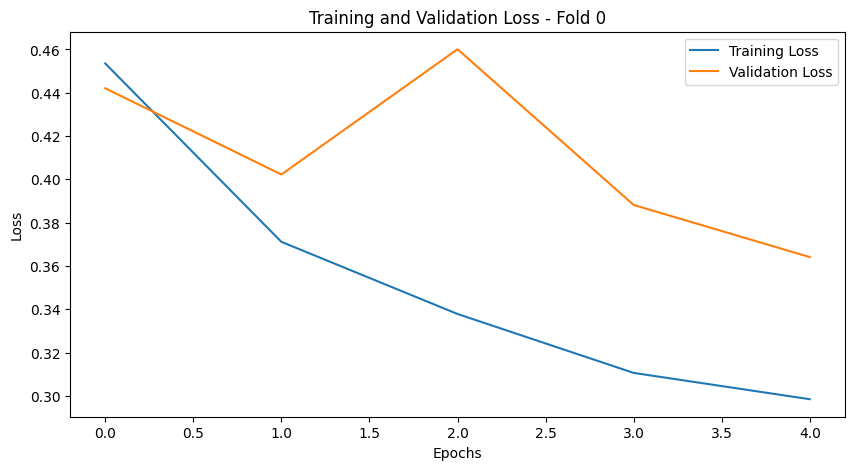

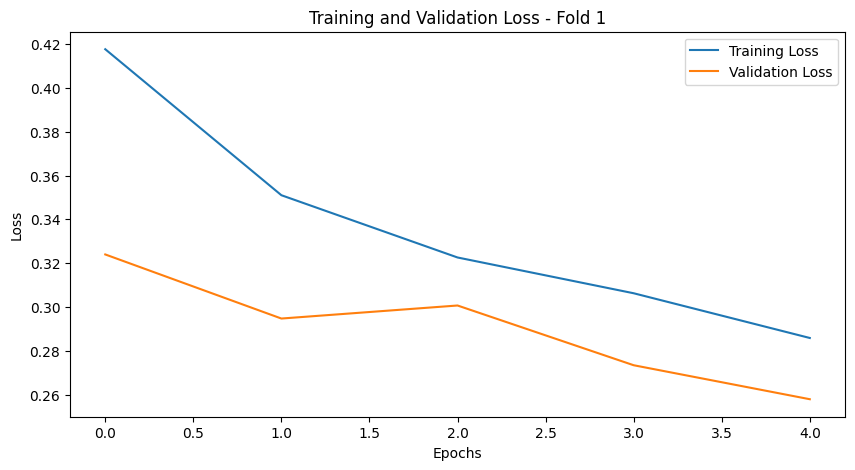

In [25]:
if __name__ == "__main__":
    img_dir = '/content/chipped_dataset'

    model, fold_results = train_unet_crossval(
        img_dir=img_dir,
        epochs=5,
        batch_size=8,
        n_classes=2,
        n_channels=8,
        sensor='planet',
        train_folds=[0, 1]  # Only train on first two folds
    )

    # Print results
    print("\n=== Cross-Validation Results ===")
    for result in fold_results:
        print(f"Fold {result['fold'] + 1}:")
        print(f"  Best Val Loss: {result['best_val_loss']:.4f}")
        print(f"  Best Val F1: {result['best_val_f1']:.4f}")
        print(f"  Best Val IoU: {result['best_val_iou']:.4f}")